## Early Prediction of Sepsis using Deep Learning Ensemble

**Team:**
* Manasa Nandimandalam (mfn5335@psu.edu)
* Danica Chanda (dzc5829@psu.edu)

**Course:** DAAN 897– Deep Learning (Spring II, 2023)

### Problem Statement
* This project aims to detect sepsis early on using physiological data. Here, we aim to predict sepsis 6 hours before the clinical prediction of sepsis. The aim is to design and implement a model that can, based on only the clinical information provided, automatically identify a patient's risk of sepsis.
    
    
    
**Keywords**: Sepsis, prediction, clinical
	

### Data Collection
* Source(url): https://physionet.org/content/challenge-2019/1.0.0/
* Short Description : The dataset available for training is collected for ICU patients and comes from three different hospital systems. 40,336 files, divided into training set A (20,336) and training set B (20,000), are provided with each file consisting of data pertaining to a patient suffering with infection with records for each hour during the treatment. 

* Keywords: ICU patients, treatment, training, testing

### Required packages

In [ ]:
pip install tensorflow
pip install keras
pip install imblearn

### Data Preprocessing

**Step-1**: We have two training sets set-A and set-B. Reading the files from each setA

In [1]:
import numpy as np
import os
import glob
import pandas as pd
from collections import Counter
import time
np.random.seed(1111)

_**Defining functions to extarct the patient id from the file name and extract the rolling window sequence for each patient file**_

In [2]:
# Defining a function to extract PatientID from the file path
import re
def extractPatientID(path):
    pattern = r'p(\d{6})\.psv'
    match = re.search(pattern, path)
    patient_id = match.group(1).lstrip('0')
    patient_id = int(patient_id)
    return patient_id

def extractWindowSequence(df, window):
    num_rows = df.shape[0]
    sequence = []
    window_label = []
    y = df['SepsisLabel'].max()
    for i in range(0, num_rows-window):
        x = df[i:i+window]
        window_label.append(y)
        sequence.append(x.drop(['SepsisLabel'], axis = 1).values)
    return sequence, window_label

_**Listing all the files present in set-A**_

In [3]:
files_A = glob.glob( "./training_setA/training/*")
print("Total number of files: ", len(files_A))
print("Showing first 10 files...")
files_A[:10]

Total number of files:  20336
Showing first 10 files...


['./training_setA/training\\p000001.psv',
 './training_setA/training\\p000002.psv',
 './training_setA/training\\p000003.psv',
 './training_setA/training\\p000004.psv',
 './training_setA/training\\p000005.psv',
 './training_setA/training\\p000006.psv',
 './training_setA/training\\p000007.psv',
 './training_setA/training\\p000008.psv',
 './training_setA/training\\p000009.psv',
 './training_setA/training\\p000010.psv']

_**Reading all the files from set-A and creating list of sequences**_
1. Performing the KNN with 2 nearest neighbours for imputing the missing values for each patient file.
2. Dropping the columns 'Bilirubin_direct','TroponinI','Fibrinogen','Unit1','Unit2','HospAdmTime','Gender' by the judgement that came from referring to multiple reasearch papers.
3. Creating list of sequences from all the files with a rolling window of 12 records and labeling the sequence based on whether the patient is septic or not

In [4]:
#Read all the files and create a master dataframe
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 10)

df_master_A = pd.DataFrame()

sequences_A = []
window = 12

label_A = []
window_labels_A = []
start_time = time.time()


for file in files_A:
    
    df_raw = pd.read_csv(file, sep ='|', )
    df_raw.drop(['Bilirubin_direct','TroponinI','Fibrinogen','Unit1','Unit2','HospAdmTime','Gender'],axis=1, inplace=True)
    null_cols = df_raw.columns[df_raw.isnull().all()].tolist()
    df = df_raw.drop(null_cols, axis=1)
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    
    for col in null_cols:
        df[col] = df_raw[col]
    
    patient_id = extractPatientID(file)
    df['PatientID'] = [patient_id]*df.shape[0]
    
    if patient_id%1000 == 0:
        print('Reading patient file: ', patient_id)    
    df.fillna(0, inplace=True)
    
    x, y = extractWindowSequence(df, window)
    sequences_A = sequences_A + x
    window_labels_A = window_labels_A + y
    

Reading patient file:  1000
Reading patient file:  2000
Reading patient file:  3000
Reading patient file:  4000
Reading patient file:  5000
Reading patient file:  6000
Reading patient file:  7000
Reading patient file:  8000
Reading patient file:  9000
Reading patient file:  10000
Reading patient file:  11000
Reading patient file:  12000
Reading patient file:  13000
Reading patient file:  14000
Reading patient file:  15000
Reading patient file:  16000
Reading patient file:  17000
Reading patient file:  18000
Reading patient file:  19000
Reading patient file:  20000


_**Listing all the files present in set-B**_

In [6]:
files_B = glob.glob( "./training_setB/training_setB/*")
print("Total number of files: ", len(files_B))
print("Showing first 10 files...")
files_B[:10]

Total number of files:  20000
Showing first 10 files...


['./training_setB/training_setB\\p100001.psv',
 './training_setB/training_setB\\p100002.psv',
 './training_setB/training_setB\\p100003.psv',
 './training_setB/training_setB\\p100004.psv',
 './training_setB/training_setB\\p100005.psv',
 './training_setB/training_setB\\p100006.psv',
 './training_setB/training_setB\\p100007.psv',
 './training_setB/training_setB\\p100008.psv',
 './training_setB/training_setB\\p100009.psv',
 './training_setB/training_setB\\p100010.psv']

_**Reading all the files from set-B and creating list of sequences**_
1. Performing the KNN with 2 nearest neighbours for imputing the missing values for each patient file.
2. Dropping the columns 'Bilirubin_direct','TroponinI','Fibrinogen','Unit1','Unit2','HospAdmTime','Gender' by the judgement that came from referring to multiple reasearch papers.
3. Creating list of sequences from all the files with a rolling window of 12 records and labeling the sequence based on whether the patient is septic or not

In [7]:
df_master_B = pd.DataFrame()

sequences_B = []
window = 12

label_B = []
window_labels_B = []
start_time = time.time()


for file in files_B:
    
    df_raw = pd.read_csv(file, sep ='|', )
    df_raw.drop(['Bilirubin_direct','TroponinI','Fibrinogen','Unit1','Unit2','HospAdmTime','Gender'],axis=1, inplace=True)
    null_cols = df_raw.columns[df_raw.isnull().all()].tolist()
    df = df_raw.drop(null_cols, axis=1)
    df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)
    
    for col in null_cols:
        df[col] = df_raw[col]
    
    patient_id = extractPatientID(file)
    df['PatientID'] = [patient_id]*df.shape[0]
    
    if patient_id%1000 == 0:
        print('Reading patient file: ', patient_id)    
    df.fillna(0, inplace=True)
    
    x, y = extractWindowSequence(df, window)
    sequences_B = sequences_B + x
    window_labels_B = window_labels_B + y

Reading patient file:  101000
Reading patient file:  102000
Reading patient file:  103000
Reading patient file:  104000
Reading patient file:  105000
Reading patient file:  106000
Reading patient file:  107000
Reading patient file:  108000
Reading patient file:  109000
Reading patient file:  110000
Reading patient file:  111000
Reading patient file:  112000
Reading patient file:  113000
Reading patient file:  114000
Reading patient file:  115000
Reading patient file:  116000
Reading patient file:  117000
Reading patient file:  118000
Reading patient file:  119000
Reading patient file:  120000


_**Combining the data from both the sets to create one master dataset**_

In [8]:
sequences = sequences_A + sequences_B
window_labels = window_labels_A + window_labels_B

_**Checking number of sequence records created**_

In [9]:
print("No of sequences: ",len(sequences))
print("No of labels : ", len(window_labels))

No of sequences:  1070874
No of labels :  1070874


_**Checking if the training data is imbalanced by counting the no of septic and non-septic labels**_
<br>We found that the training data is imbalanced with 87% of class '0' and 13% of class '1'

In [10]:
label_count = Counter(window_labels)

print("Train Data")
print("Total no.of records: ",len(window_labels))
print("No of septic records: ", label_count[1], f'{round((label_count[1]/len(window_labels)), 2)*100}%')
print("No of non-septic records: ", label_count[0], f'{round((label_count[0]/len(window_labels)), 2)*100}%')

Train Data
Total no.of records:  1070874
No of septic records:  138803 13.0%
No of non-septic records:  932071 87.0%


_**Calculating the ratio of non-septic labels to the septic labels**_
<br>We found that there are 6 non-septic labels for every septic label

In [17]:
932071/138803

6.7150637954511065

### Preparing the data

_**Splitting the data into train, validation and test sets in the ratio 60:20:20**_
<br> As we found out that our data is imbalanced we have used stratified sampling to split the data

In [11]:
X = np.array(sequences)
y = np.array(window_labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

_**Checking the distribution of classes in the train and test sets**_
<br> The distribution is same across both the sets

In [12]:
label_count = Counter(y_train)

print("Train Data")
print("Total no.of records: ",len(y_train))
print("No of septic records: ", label_count[1], f'{round((label_count[1]/len(y_train)), 2)*100}%')
print("No of non-septic records: ", label_count[0], f'{round((label_count[0]/len(y_train)), 2)*100}%')

label_count = Counter(y_test)

print("\nTest Data")
print("Total no.of records: ",len(y_test))
print("No of septic records: ", label_count[1], f'{round((label_count[1]/len(y_test)), 2)*100}%')
print("No of non-septic records: ", label_count[0], f'{round((label_count[0]/len(y_test)), 2)*100}%')

Train Data
Total no.of records:  685359
No of septic records:  88834 13.0%
No of non-septic records:  596525 87.0%

Test Data
Total no.of records:  214175
No of septic records:  27761 13.0%
No of non-septic records:  186414 87.0%


### Methodology

First, we pre-process our data. We use fill-forward method to fill in the missing values. After this, we fill in the missing values in the first row with zero. 
Once the pre-processing is done, we do feature selection. We use past papers to decide on the features that are most important and remove the ones that haven't been used previously. Additionally, the data also had multiple columns with only null values; they were removed.
Then we perform padding to the dataset.
Once the dataset is ready for further analysis. We implement a CNN Model and an LSTM model.
Consequently, we shall compare the performance of both models and infer the results.
 
 * LSTM Model
    * First, we use LSTM model to predict sepsis in patients.
    This makes LSTM an effective algorithm for analyzing clinical data that contains a time component, such as time-stamped vital sign measurements and laboratory test results. LSTM networks can be used to analyze time series data from a patient's clinical record, and make predictions about the likelihood of developing sepsis.
 * GRU Model
     * Secondly we use Gated Recurrent unit Network for better computational time.
     We try changing parameters for optimizers, learning rate etc to improve the performance over LSTM model. 
 * CNN Model
    * Finally, we use the CNN model to predict sepsis in patients.
    Convolutional neural network (CNN), a class of artificial neural networks that has become dominant in various computer vision tasks, is attracting interest across a variety of domains, including radiology (Yamashita, R., Nishio, M., Do, R.K.G. et al., 2018).
Clinical data such as vital signs, laboratory results, and other patient information can be fed into the CNN model, which will then automatically learn to extract features from the data that are relevant to the early detection of sepsis.
 
3. Add keywords  
**Keywords:** CNN, LSTM, feature selection, fill-forward method

## LSTM Model

### Model Fitting and Validation

In [20]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense


keras.backend.clear_session()
# Define the model architecture
model = Sequential()
model.add(LSTM(units=128, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(500, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation = 'sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.01), metrics = ['acc'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               83456     
                                                                 
 dense (Dense)               (None, 500)               64500     
                                                                 
 dense_1 (Dense)             (None, 256)               128256    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 294,773
Trainable params: 294,773
Non-trai

In [21]:
class_weight = {0: 1., 1: 6.}
histrory = model.fit(X_train, y_train, epochs = 10, validation_data = (X_val, y_val), batch_size = 1000, class_weight=class_weight)

Epoch 1/10
686/686 [==============================] - 188s 273ms/step - loss: 1.0010 - acc: 0.7586 - val_loss: 0.5054 - val_acc: 0.7886
Epoch 2/10
686/686 [==============================] - 182s 266ms/step - loss: 0.9213 - acc: 0.7825 - val_loss: 0.5157 - val_acc: 0.7582
Epoch 3/10
686/686 [==============================] - 180s 263ms/step - loss: 0.9156 - acc: 0.7538 - val_loss: 0.4595 - val_acc: 0.8051
Epoch 4/10
686/686 [==============================] - 175s 256ms/step - loss: 0.8787 - acc: 0.7725 - val_loss: 0.4917 - val_acc: 0.7970
Epoch 5/10
686/686 [==============================] - 173s 252ms/step - loss: 0.8898 - acc: 0.7697 - val_loss: 0.4625 - val_acc: 0.7843
Epoch 6/10
686/686 [==============================] - 166s 243ms/step - loss: 0.8939 - acc: 0.7915 - val_loss: 0.7135 - val_acc: 0.5146
Epoch 7/10
686/686 [==============================] - 165s 240ms/step - loss: 0.8707 - acc: 0.7872 - val_loss: 0.4518 - val_acc: 0.8034
Epoch 8/10
686/686 [============================

### Model Evaluation

_**Defining functions to plot learning graphs and classification report**_

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_graph(history):

  #Finding average for each cross-fold
    loss = history.history['loss']
    accuracy = history.history['acc']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy curves
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [69]:
import array
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, RocCurveDisplay, classification_report

def classification_report_plot(y_pred, y_true):
    y_pred = [int(np.round(x,0)) for x in y_pred]
    cf_matrix = confusion_matrix(y_true, y_pred)
    print("\nClassification Report\n")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion matrix\n")
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap='Blues')
    plt.show()
    
    RocCurveDisplay.from_predictions(y_true, y_pred)
    print('\nReciever Operating Characteristic Curve\n')
    plt.show()

_**plotting the learning graphs**_

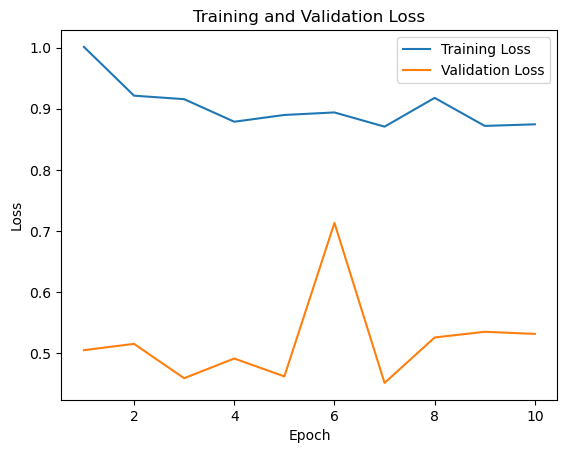

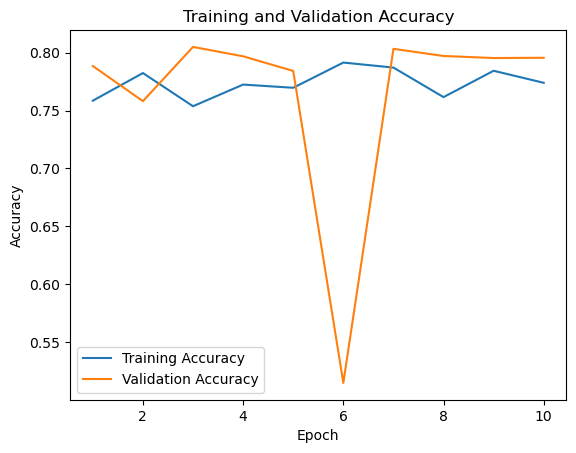

In [23]:
plot_learning_graph(histrory)

_**Calculating the accuracy for test data**_

In [24]:
from sklearn.metrics import classification_report
loss, accuracy = model.evaluate(X_test, y_test)

6693/6693 [==============================] - 33s 5ms/step - loss: 0.5299 - acc: 0.7963


_**Classification Report**_

6693/6693 [==============================] - 27s 4ms/step

Classification Report

              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87    186414
         1.0       0.36      0.72      0.48     27761

    accuracy                           0.80    214175
   macro avg       0.65      0.76      0.68    214175
weighted avg       0.87      0.80      0.82    214175


Confusion matrix



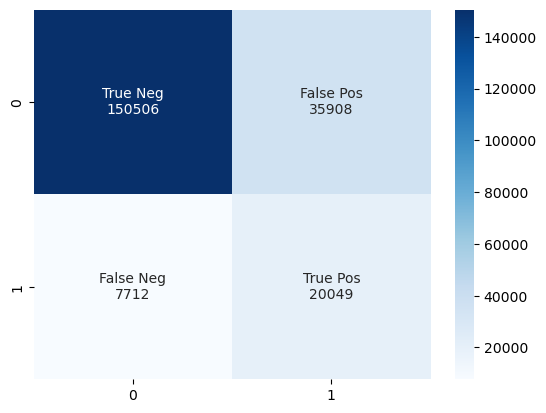


Reciever Operating Characteristic Curve



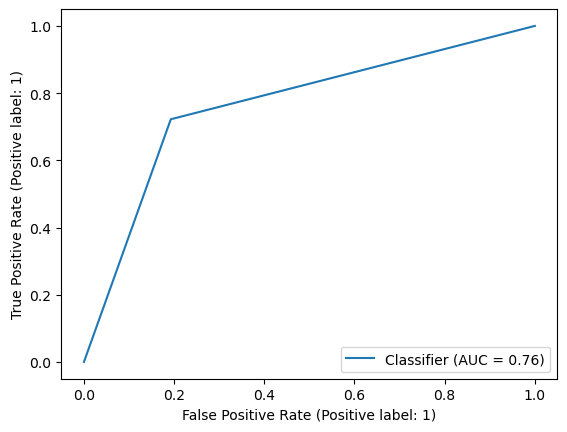

In [70]:
y_pred = model.predict(X_test)
classification_report_plot(y_pred, y_test)

_**Sensitivity**_ = True Positives / (True Positives + False Negatives) = 0.722
<br>_**Specificity**_ = True Negatives / (True Negatives + False Positives) = 0.807

_**Saving the model weights**_

In [46]:
model.save_weights('LSTM_baseModel.h5')

### Issues / Improvements

1. The learning graphs for loss and accuracy do not show a good improvement over the epochs.
2. Moreover, we have seen an erratic drop in the accuracy for the validation during the training.
3. However the final train accuracy, validation accuracy and test accuracy look consistent.
4. As our dataset is imbalanced we have considered the AUROC metric to judge the performance of the model. We have achieved AUROC of 0.76 whch gives evidence for good performing model.
5. Using LSTM model each epoch took 170 seconds to run.

## GRU Model

### Model Fitting and Validation

In [54]:
#Adding Kernel Regularization with ElasticNet
from keras.optimizers import RMSprop, SGD
from keras.layers import Dropout
from keras.layers import GRU, Dense
from keras.regularizers import L1

keras.backend.clear_session()
# Define the model architecture

keras.backend.clear_session()
# Define the model architecture
GRUmodel_1 = Sequential()
GRUmodel_1.add(GRU(units=128, input_shape=(X.shape[1], X.shape[2]), kernel_regularizer = L1(0.1)))
GRUmodel_1.add(Dense(500, activation='relu'))
GRUmodel_1.add(Dense(256, activation='relu'))
GRUmodel_1.add(Dense(64, activation='relu'))
GRUmodel_1.add(Dense(32, activation='relu'))
GRUmodel_1.add(Dense(1,activation = 'sigmoid'))

# Compile the model
GRUmodel_1.compile(loss='binary_crossentropy', optimizer= SGD(learning_rate = 0.01), metrics = ['acc'])

# Print the model summary
GRUmodel_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               62976     
                                                                 
 dense (Dense)               (None, 500)               64500     
                                                                 
 dense_1 (Dense)             (None, 256)               128256    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 274,293
Trainable params: 274,293
Non-trai

_**Using class weights to treat the imbalances in the data**_

In [55]:
class_weight = {0: 1., 1: 6.}
GRUmodel_1history = GRUmodel_1.fit(X_train, y_train, epochs  = 10, validation_data = (X_val, y_val), batch_size = 1000, class_weight=class_weight)

Epoch 1/10
686/686 [==============================] - 102s 147ms/step - loss: 9.9067 - acc: 0.7140 - val_loss: 6.3052 - val_acc: 0.8702
Epoch 2/10
686/686 [==============================] - 101s 147ms/step - loss: 6.0128 - acc: 0.8015 - val_loss: 5.0576 - val_acc: 0.8704
Epoch 3/10
686/686 [==============================] - 101s 147ms/step - loss: 5.8878 - acc: 0.8048 - val_loss: 5.3773 - val_acc: 0.8704
Epoch 4/10
686/686 [==============================] - 100s 146ms/step - loss: 5.8775 - acc: 0.8185 - val_loss: 5.0546 - val_acc: 0.8704
Epoch 5/10
686/686 [==============================] - 100s 146ms/step - loss: 5.3397 - acc: 0.8512 - val_loss: 4.3931 - val_acc: 0.8704
Epoch 6/10
686/686 [==============================] - 101s 147ms/step - loss: 5.3527 - acc: 0.8499 - val_loss: 5.5984 - val_acc: 0.8705
Epoch 7/10
686/686 [==============================] - 100s 146ms/step - loss: 5.9153 - acc: 0.8527 - val_loss: 5.3068 - val_acc: 0.8704
Epoch 8/10
686/686 [============================

### Model Evaluation

_**Calculating the accuracy for test data**_

In [71]:
GRUmodel_1.evaluate(X_test, y_test)

6693/6693 [==============================] - 23s 3ms/step - loss: 4.2818 - acc: 0.8704


[4.281835079193115, 0.8703817129135132]

_**plotting the learning graphs**_

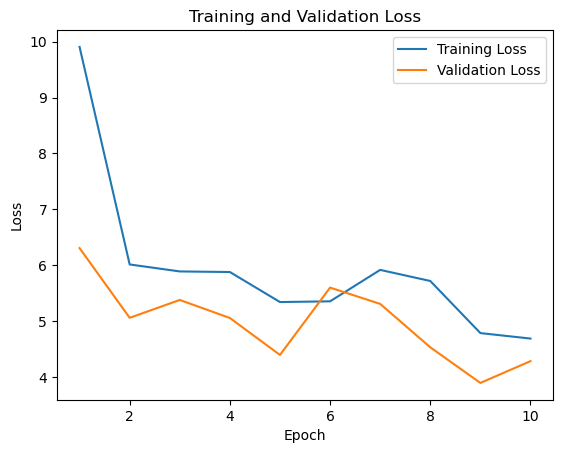

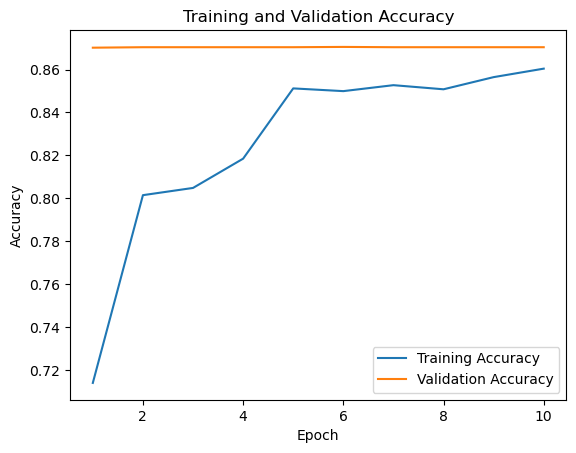

In [56]:
plot_learning_graph(GRUmodel_1history)

_**Saving the model weights**_

In [72]:
GRUmodel_1.save_weights('GRUmodel.h5')

_**Printing the classification report**_

6693/6693 [==============================] - 29s 4ms/step

Classification Report

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93    186414
         1.0       0.00      0.00      0.00     27761

    accuracy                           0.87    214175
   macro avg       0.44      0.50      0.47    214175
weighted avg       0.76      0.87      0.81    214175


Confusion matrix



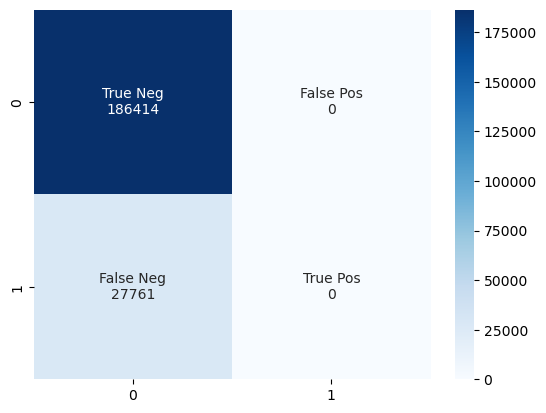


Reciever Operating Characteristic Curve



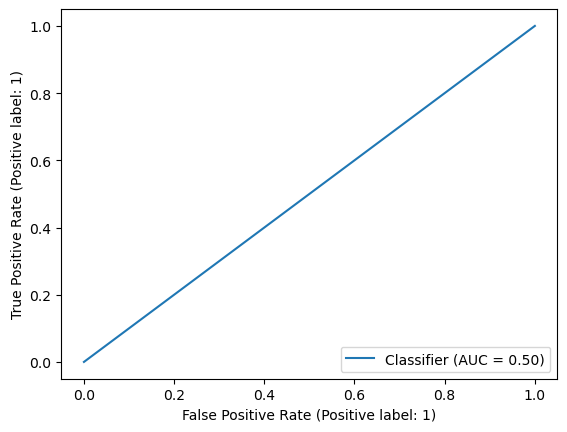

In [74]:
import warnings
warnings.filterwarnings("ignore")

y_pred = GRUmodel_1.predict(X_test)
classification_report_plot(y_pred, y_test)

_**Sensitivity**_ = True Positives / (True Positives + False Negatives) = 0
<br>_**Specificity**_ = True Negatives / (True Negatives + False Positives) = 1

### Issues / Improvements

1. We have used Stochoist Gradient Descent (SGD) optimizer in place of Adam used in LSTM model to smoothen the learning curves. The learning curve for loss function shows a great improvement over the LSTM model but compromised by the learning curce for accuracy. We see literally no improvement in the validation accuracy over the epochs.
2. The final train, validation and test accuracy are however better than that of LSTM model.
3. As our dataset is imbalanced we have considered the AUROC metric to judge the performance of the model. We have achieved AUROC of 0.50 using GRU model which says the model no good than a random guesser.
4. Take away from this model would be that SGD works good as an optimizer over Adam.
5. GRU trained much faster than LSTM with an average of 100 seconds for the same batch size.

# CNN Model

### Model Fitting and Validation

From the learnings of previous model trainig we will be using
1. Stochoistic Gradient Descend (SGD) as an optimizer
2. We will be using Batch Normalization layer to scale the data between the layers.
3. Use Kernel Initializer as 'he_uniform' to uniformly initialize the weights of the network.
4. Dropout layer to avoid overfitting

In [62]:
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization


CNN_model = Sequential()
CNN_model.add(Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', input_shape=(X.shape[1], X.shape[2], 1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization(center=True, scale=True))
CNN_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization(center=True, scale=True))
CNN_model.add(Dropout(0.5))
CNN_model.add(Flatten())
CNN_model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
CNN_model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
CNN_model.add(Dense(1, activation='sigmoid'))

CNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 10, 32, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 16, 32)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 5, 16, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 14, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 7, 64)         0         
 2D)                                                             
                                                      

In [64]:
CNN_model.compile(loss='binary_crossentropy', optimizer= SGD(learning_rate = 0.01), metrics = ['acc'])

In [65]:
class_weight = {0: 1., 1: 6.}
CNN_modelhistory = CNN_model.fit(X_train, y_train, epochs  = 10, validation_data = (X_val, y_val), batch_size = 1000, class_weight=class_weight)

Epoch 1/10
686/686 [==============================] - 90s 130ms/step - loss: 0.9149 - acc: 0.7494 - val_loss: 0.4689 - val_acc: 0.7866
Epoch 2/10
686/686 [==============================] - 89s 129ms/step - loss: 0.8170 - acc: 0.7862 - val_loss: 0.5066 - val_acc: 0.7653
Epoch 3/10
686/686 [==============================] - 89s 129ms/step - loss: 0.7760 - acc: 0.8021 - val_loss: 0.3950 - val_acc: 0.8269
Epoch 4/10
686/686 [==============================] - 89s 129ms/step - loss: 0.7531 - acc: 0.8094 - val_loss: 0.3578 - val_acc: 0.8442
Epoch 5/10
686/686 [==============================] - 89s 130ms/step - loss: 0.7385 - acc: 0.8133 - val_loss: 0.3974 - val_acc: 0.8170
Epoch 6/10
686/686 [==============================] - 89s 129ms/step - loss: 0.7300 - acc: 0.8146 - val_loss: 0.3679 - val_acc: 0.8332
Epoch 7/10
686/686 [==============================] - 89s 129ms/step - loss: 0.7231 - acc: 0.8171 - val_loss: 0.3668 - val_acc: 0.8346
Epoch 8/10
686/686 [==============================] - 8

### Model Evaluation

_**Plotting the learning curves**_

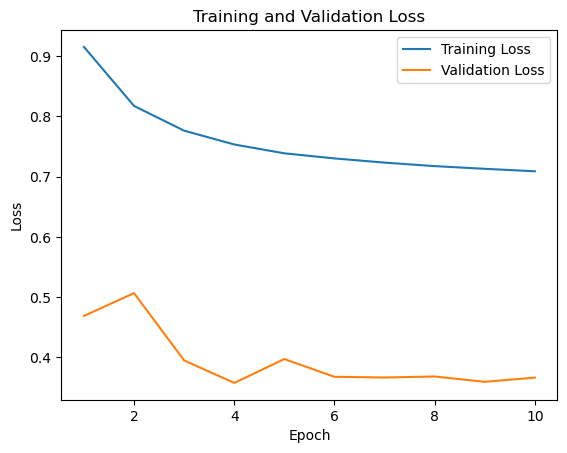

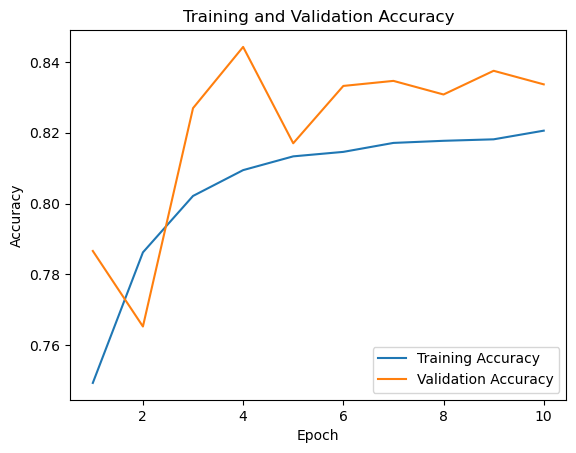

In [66]:
plot_learning_graph(CNN_modelhistory)

_**Printing the classification report**_

6693/6693 [==============================] - 27s 4ms/step

Classification Report

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90    186414
         1.0       0.43      0.77      0.55     27761

    accuracy                           0.84    214175
   macro avg       0.69      0.81      0.72    214175
weighted avg       0.89      0.84      0.85    214175


Confusion matrix



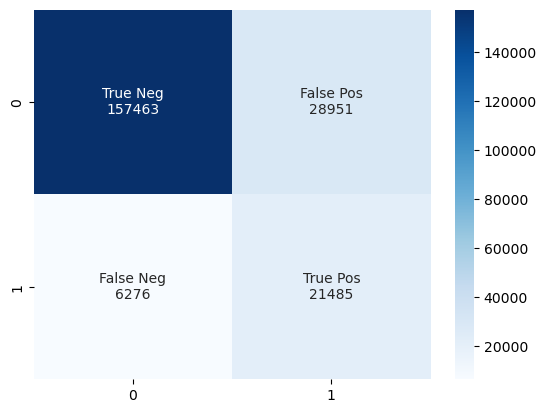


Reciever Operating Characteristic Curve



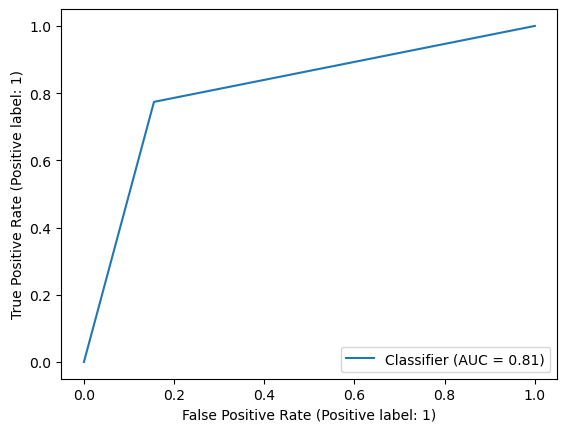

In [75]:
y_pred = CNN_model.predict(X_test)
classification_report_plot(y_pred, y_test)

_**Sensitivity**_ = True Positives / (True Positives + False Negatives) = 0.774
<br>_**Specificity**_ = True Negatives / (True Negatives + False Positives) = 0.845

_**Calculating the accuracy on test data**_

In [78]:
CNN_model.evaluate(X_test, y_test)

6693/6693 [==============================] - 27s 4ms/step - loss: 0.3644 - acc: 0.8355


[0.3643862307071686, 0.8355223536491394]

_**Saving the model weights**_

In [76]:
CNN_model.save_weights('CNNmodel.h5')

### Issues / Improvements

1. We have used Stochoist Gradient Descent (SGD) optimizer in place of Adam used in LSTM model to smoothen the learning curves. The learning curve for loss function shows a an improvement over LSTM model though not as great as GRU model. But the learning curce for accuracy has shown a lot of improvement over LSTM and GRU models. We can that the train accuracy and validation accuracy increase over the epochs. Batch Normalization has worked its best!
2. No overfitting or underfitting
3. The final train, validation and test accuracy are however better than that of both previous models.
4. The AUROC of 0.81 has a lot of improvement over LSTM and GRU models.
5. Oveall we consider CNN as our best model.

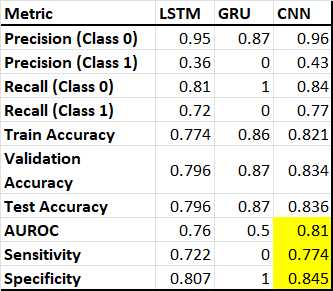

_**Sensitivity is an important metric when it comes to dealing with medical data. <br>The sensitivity for our best model 0.774 tells us that from 100 cases that have positive septic condition our model identifies 77 cases. <br>Whereas the specificity indicates that out of 100 cases that are negative for septic condition our model correctly identifies 84 cases.**_

### References

* https://github.com/christianversloot/machine-learning-articles/blob/main/a-simple-conv3d-example-with-keras.md
